In [1198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import spatial
from collections import defaultdict
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, auc, f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, mean_squared_error, classification_report
from sklearn import cross_validation, datasets, grid_search, ensemble, tree, cluster, pipeline, manifold, preprocessing, feature_selection, decomposition
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.learning_curve import learning_curve
from sklearn.base import BaseEstimator, TransformerMixin
from treeinterpreter import treeinterpreter as ti
from census import Census
from us import states
import warnings
import itertools
import pickle
warnings.filterwarnings('ignore')
%matplotlib inline

In [873]:
airbnb = pd.read_csv('listings.csv')

In [874]:
df_ = airbnb.dropna(axis = 0, subset = ['latitude', 'longitude'])

In [875]:
df_['coordinates'] = zip(df_['latitude'],df_['longitude'])

In [876]:
df_['coordinates'] = df_['coordinates'].apply(list)

In [877]:
with open('coord_dict.pickle', 'rb') as handle:
    coords_dict = pickle.load(handle)

In [878]:
def to_list(dictionary):
    for key, value in dictionary.iteritems():
        v = list(value)
        dictionary[key] = v
    return dictionary

In [879]:
coords_dict_2 = to_list(coords_dict)

In [880]:
x_coord = coords_dict_2.values()
y_coord = coords_dict_2.keys()
lat_long = list(df_['coordinates'])

In [881]:
def nearest(X_train, y_train, X_test):
    tree = spatial.KDTree(np.array(X_train))
    (distances,indexes) = tree.query(X_test)
    for i,d in zip(indexes,distances):
        #yield y_train[i] + ' is {} parsecs away'.format(d)
        yield y_train[i]

In [882]:
results =[]
for result in nearest(x_coord, y_coord, lat_long):
    results.append(result)

In [883]:
df_['GEOID'] = results

In [884]:
df_['dailyrate'] = df_['price'].replace('[\$,]','',regex=True).astype(float)

In [885]:
df_a = pd.pivot_table(df_, index='GEOID', values=['number_of_reviews', 'accommodates', 'bathrooms', 'review_scores_location',
                                                  'bedrooms', 'beds', 'dailyrate', 'review_scores_rating'],
                     aggfunc=[np.mean,len])

In [886]:
df_b = df_a['mean']
df_c = df_a['len']

In [887]:
df_b['airbnb_listings'] = df_c['dailyrate']

In [888]:
df_b = df_b.reset_index()

In [902]:
county = ['5', '47', '61', '81', '85']
county_s = []
for c in county:
    county_s.append('state:{} county: %s' % c)
t = []
t10 = []

In [903]:
c = Census("564d24cd9cc31d5fc6f7438d4cb5d9537d739c26")
#c = Census("262544deef0a6384fe452d5d2173d31aa6a3279c", year=2013)

In [904]:
for i in county_s:
    r = c.acs5.get(('NAME', 'B01001_001E', 'B01001_002E', 'B01001A_001E', 'B01002_001E', 'B08131_001E',
                 'B19013_001E', 'B25001_001E', 'B25002_002E', 'B25003_002E', 'B25003_003E', 'B25107_001E', 
                 'B25111_001E', 'B09001_001E', 'B11001_001E', 'B25088_002E', 'B25088_003E', 'B17001_002E', 
                 'B06009_001E', 'B06009_002E', 'B06009_003E', 'B06009_004E', 'B06009_005E', 'B06009_006E', 
                 'B25004_001E', 'B25057_001E', 'B25058_001E', 'B25059_001E', 'B08134_001E', 'B25092_002E', 
                 'B25103_002E'), geo={'for': 'tract:*',
                       'in': i.format(states.NY.fips)})
    t.append(r)

In [905]:
c10 = Census("262544deef0a6384fe452d5d2173d31aa6a3279c", year=2011)

In [907]:
for i in county_s:
    s = c10.acs5.get(('NAME', 'B01001_001E', 'B01001_002E', 'B01001A_001E', 'B01002_001E', 'B08131_001E',
                 'B19013_001E', 'B25001_001E', 'B25002_002E', 'B25003_002E', 'B25003_003E', 'B25107_001E', 
                 'B25111_001E', 'B09001_001E', 'B11001_001E', 'B25088_002E', 'B25088_003E', 'B17001_002E', 
                 'B06009_001E', 'B06009_002E', 'B06009_003E', 'B06009_004E', 'B06009_005E', 'B06009_006E', 
                 'B25004_001E', 'B25057_001E', 'B25058_001E', 'B25059_001E', 'B25092_002E', 
                 'B25103_002E'), geo={'for': 'tract:*',
                       'in': i.format(states.NY.fips)}, year=2011)
    t10.append(s)

In [908]:
#test = c.acs5.get(('NAME', 'B25088_001E', 'B25087_002E', 'B25088_003E'), geo={'for': 'tract:*',
#                       'in': 'state:{} county:5'.format(states.NY.fips)})

In [909]:
d = defaultdict(list)
for x in t:
    for i in range(len(x)):
        d['housing_units'].append(x[i]['B25001_001E'])
        d['housing_occupied'].append(x[i]['B25002_002E'])
        d['housing_owner_occupied'].append(x[i]['B25003_002E'])
        d['housing_renter_occupied'].append(x[i]['B25003_003E'])
        d['housing_median_value'].append(x[i]['B25107_001E'])
        d['gross_rent_median'].append(x[i]['B25111_001E'])
        d['contract_rent_50q'].append(x[i]['B25058_001E'])
        d['contract_rent_25q'].append(x[i]['B25057_001E'])
        d['contract_rent_75q'].append(x[i]['B25059_001E'])
        d['vacancy'].append(x[i]['B25004_001E'])
        d['population_under18'].append(x[i]['B09001_001E'])        
        d['households'].append(x[i]['B11001_001E'])
        d['population'].append(x[i]['B01001_001E'])
        d['housingcost_w_mortgage'].append(x[i]['B25088_002E'])
        d['housingcost_wo_mortgage'].append(x[i]['B25088_003E'])
        d['mort_cost_%_of_income'].append(x[i]['B25092_002E'])
        d['rs_tax_median_w_mort'].append(x[i]['B25103_002E'])
        d['poverty'].append(x[i]['B17001_002E'])
        d['pop_over25_edu'].append(x[i]['B06009_001E'])
        d['pop_over25_edu_less_HS'].append(x[i]['B06009_002E'])
        d['pop_over25_edu_HS'].append(x[i]['B06009_003E'])
        d['pop_over25_edu_coll'].append(x[i]['B06009_004E'])
        d['pop_over25_edu_bach'].append(x[i]['B06009_005E'])
        d['pop_over25_edu_grad'].append(x[i]['B06009_006E'])
        d['male'].append(x[i]['B01001_002E'])
        d['white'].append(x[i]['B01001A_001E'])
        d['age_median'].append(x[i]['B01002_001E'])
        d['agg_travel_time'].append(x[i]['B08131_001E'])
        d['pop_over16_work'].append(x[i]['B08134_001E'])
        d['household_income_median'].append(x[i]['B19013_001E'])
        d['county'].append(x[i]['county'])
        d['tract'].append(x[i]['tract'])

In [910]:
for x in t10:
    for i in range(len(x)):
        d['housing_units_2011'].append(x[i]['B25001_001E'])
        d['housing_median_value_2011'].append(x[i]['B25107_001E'])
        d['gross_rent_median_2011'].append(x[i]['B25111_001E'])
        d['population_2011'].append(x[i]['B01001_001E'])
        d['housingcost_w_mort_2011'].append(x[i]['B25088_002E'])
        d['housingcost_wo_mort_2011'].append(x[i]['B25088_003E'])
        d['mort_cost_%_of_income_2011'].append(x[i]['B25092_002E'])
        d['poverty_2011'].append(x[i]['B17001_002E'])
        d['agg_travel_time_2011'].append(x[i]['B08131_001E'])
        d['household_income_median_2011'].append(x[i]['B19013_001E'])

In [911]:
cen = pd.DataFrame(d)

In [912]:
cen['geo_header'] = str(36)

In [913]:
cen['geoid'] = cen.geo_header + cen.county + cen.tract

In [914]:
cen['GEOID'] = cen['geoid'].map(int)

In [915]:
cen.drop('geoid', axis=1, inplace=True)

In [916]:
tract = pd.read_csv('tract_centroids.txt')

In [917]:
tract.COUNTY.unique()

array([ 5, 47, 61, 81, 85])

In [918]:
tract.drop(['Unnamed: 0', 'STATE', 'TRACT'], axis=1, inplace=True)

In [919]:
dft = pd.merge(tract, cen, how='left', on='GEOID')

In [920]:
df = pd.merge(dft, df_b, how='left', on='GEOID')

In [921]:
df['mean_travel_time'] = df['agg_travel_time'].astype(float) / df['pop_over16_work'].astype(float)

In [922]:
df['airbnb_monthly_equal'] = df['dailyrate']*30.5

In [923]:
df['airbnb_rent_mult'] = df['airbnb_monthly_equal'] / df['gross_rent_median'].astype(float)

In [924]:
df['make_rent_median'] = df['gross_rent_median'].astype(float) / df['dailyrate']

In [925]:
df['make_rent_75q'] = df['contract_rent_75q'].astype(float) / df['dailyrate']

In [926]:
df['%_occupied'] = (df['housing_occupied'].astype(float) / df['housing_units'].astype(float)) * 100

In [927]:
df['airbnb_trans'] = df[('airbnb_listings')].fillna(0).astype(int)

In [928]:
df['%_non-whites'] = ((df['population'].astype(float) - df['white'].astype(float)) / df['population'].astype(float))*100

In [929]:
df['%_vacancy'] = (df['vacancy'].astype(float) / df['housing_units'].astype(float))*100

In [930]:
df['%_poverty'] = (df['poverty'].astype(float) / df['population'].astype(float))*100

In [931]:
df['airbnb_housing_density'] = (df['airbnb_trans'] / df['housing_units'].astype(float)) *100

In [932]:
df['airbnb_rental_density'] = (df['airbnb_trans'] / df['housing_renter_occupied'].astype(float))*100

In [933]:
df['cap_rate'] = ((df['gross_rent_median'].astype(float)*12) / df['housing_median_value'].astype(float))*100

In [934]:
df['airbnb_cap_rate'] = (df['airbnb_monthly_equal']*12 / df['housing_median_value'].astype(float))*100

In [935]:
df['housing_affordability'] = (df['household_income_median'].astype(float) 
                               / (df['housingcost_w_mortgage'].astype(float) * 4 * 12)) * 100

In [936]:
df['%_hs_or_above'] = ((df['pop_over25_edu'].astype(float) - df['pop_over25_edu_less_HS'].astype(float)) / df['pop_over25_edu'].astype(float)) * 100

In [937]:
df['%_bach_or_above'] = ((df['pop_over25_edu_bach'].astype(float) + df['pop_over25_edu_grad'].astype(float)) / df['pop_over25_edu'].astype(float)) * 100

In [938]:
df['ppl_per_household'] = df['population'].astype(float) / df['households'].astype(float)

In [939]:
df['%_male'] = (df['male'].astype(float) / df['population'].astype(float)) * 100

In [940]:
df['chg_gross_rent_median'] = df['gross_rent_median'].astype(float) - df['gross_rent_median_2011'].astype(float)

In [941]:
df['chg_household_income_median'] = df['household_income_median'].astype(float) - df['household_income_median_2011'].astype(float)

In [942]:
df['chg_housing_units'] = df['housing_units'].astype(float) - df['housing_units_2011'].astype(float)

In [943]:
df['chg_population'] = df['population'].astype(float) - df['population_2011'].astype(float)

In [944]:
df['chg_housing_value_median'] = df['housing_median_value'].astype(float) - df['housing_median_value_2011'].astype(float)

In [945]:
df['chg_mort_cost'] = df['housingcost_w_mortgage'].astype(float) - df['housingcost_w_mort_2011'].astype(float)

In [946]:
df['chg_mort_cost_%_of_income'] = df['mort_cost_%_of_income'].astype(float) - df['mort_cost_%_of_income_2011'].astype(float)

In [947]:
df['%_poverty_2011'] = (df['poverty_2011'].astype(float) / df['population_2011'].astype(float))*100

In [948]:
df['chg_%_poverty'] = df['%_poverty'] - df['%_poverty_2011']

In [949]:
df['cap_rate_differential'] = df['airbnb_cap_rate'].astype(float) - df['cap_rate'].astype(float)

In [950]:
coffee = pd.read_csv('yelp_coffee.csv')

In [951]:
dfc = coffee.dropna(axis = 0, subset = ['latitude', 'longitude'])

In [952]:
dfc['coordinates'] = zip(dfc['latitude'],dfc['longitude'])

In [953]:
dfc['coordinates'] = dfc['coordinates'].apply(list)

In [954]:
lat_long_c = list(dfc['coordinates'])

In [955]:
results_c =[]
for result in nearest(x_coord, y_coord, lat_long_c):
    results_c.append(result)

In [956]:
dfc['GEOID'] = results_c

In [957]:
dfcc = pd.pivot_table(dfc, index='GEOID', values=['id'],
                     aggfunc=[len])

In [958]:
dfcc = dfcc['len'].reset_index()

In [959]:
dfcc['coffee_count'] = dfcc['id']

In [961]:
df= pd.merge(df, dfcc, how='left', on='GEOID')

In [962]:
df.coffee_count.fillna(0, inplace=True)

In [963]:
green = pd.read_csv('green_taxi.csv')
noise = pd.read_csv('noisecomplaint_data.csv')
uber = pd.read_csv('uber_data.csv')
bar = pd.read_csv('yelp_bars.csv')

In [964]:
green['green_rides'] = green['ride']
green['GEOID'] = green['census_tract']

In [965]:
green.drop(['Unnamed: 0', 'ride', 'census_tract','day_of_week','Pickup_longitude', 'Pickup_latitude','Passenger_count','Trip_distance','Total_amount','year'], axis=1, inplace=True)

In [966]:
noise['noise_count'] = noise['count']
noise['GEOID'] = noise['census_tract']

In [967]:
noise.drop(['Unnamed: 0', 'count', 'census_tract'], axis=1, inplace=True)

In [968]:
uber['uber_rides'] = uber['rides']
uber['GEOID'] = uber['census_tract']

In [969]:
uber.drop(['Unnamed: 0', 'rides', 'census_tract'], axis=1, inplace=True)

In [970]:
bar['bar_count'] = bar['count']
bar['GEOID'] = bar['census_tract']

In [971]:
bar.drop(['Unnamed: 0', 'count', 'census_tract'], axis=1, inplace=True)

In [972]:
df= pd.merge(df, green, how='left', on='GEOID')
df= pd.merge(df, noise, how='left', on='GEOID')
df= pd.merge(df, uber, how='left', on='GEOID')
df= pd.merge(df, bar, how='left', on='GEOID')

In [973]:
df.green_rides.fillna(0, inplace=True)
df.noise_count.fillna(0, inplace=True)
df.uber_rides.fillna(0, inplace=True)
df.bar_count.fillna(0, inplace=True)

In [1020]:
yellow = pd.read_csv('yellow_taxi_total.csv')

In [1022]:
yellow['yellow_rides'] = yellow['rides']
yellow['GEOID'] = yellow['census_tract']

In [1023]:
yellow.drop(['Unnamed: 0', 'rides', 'census_tract'], axis=1, inplace=True)

In [1024]:
df= pd.merge(df, yellow, how='left', on='GEOID')

In [1063]:
df.to_csv('mcnulty.csv')

In [976]:
"""def ratings(x):
    if x <5:
        return 1
    elif x < 7:
        return 2
    elif x < 9:
        return 3
    elif x < 12:
        return 4
    else:
        return 5"""

'def ratings(x):\n    if x <5:\n        return 1\n    elif x < 7:\n        return 2\n    elif x < 9:\n        return 3\n    elif x < 12:\n        return 4\n    else:\n        return 5'

In [977]:
def ratings(x):
    if x <6:
        return 1
    elif x < 10:
        return 2
    else:
        return 3 

In [1041]:
df_m = df.dropna(axis = 0, subset = ['airbnb_cap_rate'])

In [1042]:
X = df_m.loc[:,('airbnb_trans', 'gross_rent_median', 'household_income_median', 'population', 'mean_travel_time',
           '%_occupied', '%_non-whites', '%_vacancy', '%_poverty', 'airbnb_housing_density', 'airbnb_rental_density',
            'housing_affordability', '%_hs_or_above', '%_bach_or_above', 'ppl_per_household', '%_male',
             'age_median', 'rs_tax_median_w_mort', 'bathrooms', 'beds', 'number_of_reviews', 'mort_cost_%_of_income',
            'accommodates', 'bedrooms', 'review_scores_rating', 'chg_gross_rent_median', 'chg_household_income_median',
            'chg_housing_units', 'chg_population', 'chg_housing_value_median', 'chg_mort_cost', 'chg_mort_cost_%_of_income',
            'chg_%_poverty', 'cap_rate', 'coffee_count', 'green_rides', 'uber_rides', 'noise_count', 'yellow_rides')]
Y = df_m['airbnb_cap_rate'].map(ratings)

In [1043]:
Y.value_counts()

2    571
1    551
3    367
Name: airbnb_cap_rate, dtype: int64

In [1044]:
X = X.astype(float)

In [1045]:
for i in X.columns:
    fun = lambda x: X[i].mean() if pd.isnull(x) == True else x
    X[i] = X[i].apply(fun)

In [1046]:
#SELECT * FROM mcnulty_merge
#WHERE county IN (5, 47, 61, 81, 85)
#and _len_beds_ > 5

In [1047]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.30)

In [1048]:
neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(X_train,Y_train)
Y_hat_k = neigh.predict(X_test)
prob_k = neigh.predict_proba(X_test)
print 'Model: KNN'
print 'Accuracy Score  : %r' % accuracy_score(Y_test, Y_hat_k)
print 'Recall Score    : %r' % recall_score(Y_test, Y_hat_k)
print 'Precision Score : %r' % precision_score(Y_test, Y_hat_k)
print 'F1 Score        : %r' % f1_score(Y_test, Y_hat_k)

Model: KNN
Accuracy Score  : 0.45190156599552572
Recall Score    : 0.45190156599552572
Precision Score : 0.43834222191347816
F1 Score        : 0.43616474027219704


In [1230]:
model_lr = LogisticRegression(C=2, penalty='l1')
model_lr.fit(X_train, Y_train)
Y_hat_lr = model_lr.predict(X_test)
prob_lr = model_lr.predict_proba(X_test)
print 'Model: Logistic Regression'
print 'Accuracy Score  : %r' % accuracy_score(Y_test, Y_hat_lr)
print 'Recall Score    : %r' % recall_score(Y_test, Y_hat_lr)
print 'Precision Score : %r' % precision_score(Y_test, Y_hat_lr)
print 'F1 Score        : %r' % f1_score(Y_test, Y_hat_lr)

Model: Logistic Regression
Accuracy Score  : 0.65100671140939592
Recall Score    : 0.65100671140939592
Precision Score : 0.64450742868761801
F1 Score        : 0.64565371667572002


In [1050]:
gauss = GaussianNB()
gauss.fit(X_train, Y_train)
Y_hat_gauss = gauss.predict(X_test)
prob_gauss = gauss.predict_proba(X_test)
print 'Model: GaussianNB'
print 'Accuracy Score  : %r' % accuracy_score(Y_test, Y_hat_gauss)
print 'Recall Score    : %r' % recall_score(Y_test, Y_hat_gauss)
print 'Precision Score : %r' % precision_score(Y_test, Y_hat_gauss)
print 'F1 Score        : %r' % f1_score(Y_test, Y_hat_gauss)

Model: GaussianNB
Accuracy Score  : 0.50111856823266221
Recall Score    : 0.50111856823266221
Precision Score : 0.55850423237810154
F1 Score        : 0.43700030387488925


In [1217]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_hat_svc = svc.predict(X_test)
#prob_svc = svc.predict_proba(X_test)
print 'Model: DTC'
print 'Accuracy Score  : %r' % accuracy_score(Y_test, Y_hat_svc)
print 'Recall Score    : %r' % recall_score(Y_test, Y_hat_svc)
print 'Precision Score : %r' % precision_score(Y_test, Y_hat_svc)
print 'F1 Score        : %r' % f1_score(Y_test, Y_hat_svc)

Model: DTC
Accuracy Score  : 0.38031319910514544
Recall Score    : 0.38031319910514544
Precision Score : 0.14463812941358997
F1 Score        : 0.20957291360737348


In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, Y_train)
Y_hat_dtc = dtc.predict(X_test)
prob_dtc = dtc.predict_proba(X_test)
print 'Model: DTC'
print 'Accuracy Score  : %r' % accuracy_score(Y_test, Y_hat_dtc)
print 'Recall Score    : %r' % recall_score(Y_test, Y_hat_dtc)
print 'Precision Score : %r' % precision_score(Y_test, Y_hat_dtc)
print 'F1 Score        : %r' % f1_score(Y_test, Y_hat_dtc)

In [1247]:
rfc = RandomForestClassifier(max_depth=6, n_estimators=50)
rfc.fit(X_train, Y_train)
Y_hat_rfc = rfc.predict(X_test)
prob_rfc = rfc.predict_proba(X_test)
print 'Model: RFC'
print 'Accuracy Score  : %r' % accuracy_score(Y_test, Y_hat_rfc)
print 'Recall Score    : %r' % recall_score(Y_test, Y_hat_rfc)
print 'Precision Score : %r' % precision_score(Y_test, Y_hat_rfc)
print 'F1 Score        : %r' % f1_score(Y_test, Y_hat_rfc)

Model: RFC
Accuracy Score  : 0.65324384787472034
Recall Score    : 0.65324384787472034
Precision Score : 0.65419107571208135
F1 Score        : 0.6524162711405247


In [1252]:
xg = xgboost.XGBClassifier(max_depth=3, learning_rate=0.2)
xg.fit(X_train, Y_train)
Y_hat_xg = xg.predict(X_test)
prob_xg = xg.predict_proba(X_test)
print 'Model: DTC'
print 'Accuracy Score  : %r' % accuracy_score(Y_test, Y_hat_xg)
print 'Recall Score    : %r' % recall_score(Y_test, Y_hat_xg)
print 'Precision Score : %r' % precision_score(Y_test, Y_hat_xg)
print 'F1 Score        : %r' % f1_score(Y_test, Y_hat_xg)

Model: DTC
Accuracy Score  : 0.65324384787472034
Recall Score    : 0.65324384787472034
Precision Score : 0.66169606739073172
F1 Score        : 0.65517243812673964


In [1054]:
print 'Model: XGBoost'
print 'Accuracy Score  : %r' % np.mean(cross_val_score(xg, X, Y, cv=10, scoring='accuracy'))
print 'Recall Score    : %r' % np.mean(cross_val_score(xg, X, Y, cv=10, scoring='recall'))
print 'Precision Score : %r' % np.mean(cross_val_score(xg, X, Y, cv=10, scoring='precision'))
print 'F1 Score        : %r' % np.mean(cross_val_score(xg, X, Y, cv=10, scoring='f1'))

Model: XGBoost
Accuracy Score  : 0.61822183232267258
Recall Score    : 0.61822183232267258
Precision Score : 0.6433884267886617
F1 Score        : 0.61259608527954013


In [1076]:
fi = zip(X.columns, xg.feature_importances_)

In [1081]:
import seaborn as sns

In [1191]:
feat = pd.DataFrame(fi, columns=['features', 'contributions'])

In [1192]:
topfi = feat.sort_values(by='contributions', ascending=False)[0:10]

In [1193]:
flist = ['Capitalization Rate', 'Accommodation per home', 'Uber Rides', 'Number of AirBnB Reviews', 'Median Rent', 'No. of Bedrooms', 'Change in Housing Value', 'Change in Population', 'Median Real Estate Taxes', 'Average Review Scores']

In [1194]:
topfi['features'] = flist

In [1195]:
topfi = topfi.sort_values(by='contributions', ascending=True)

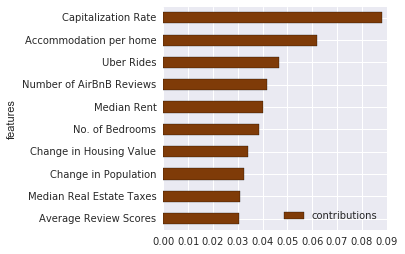

In [1196]:
topfi.plot('features', 'contributions', kind='barh', colormap="PuOr", figsize=(4,4))

In [998]:
class IdentityTransform(BaseEstimator, TransformerMixin):

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        return X


In [1056]:
combined_features = pipeline.FeatureUnion([('poly2',preprocessing.PolynomialFeatures(degree=2)),
                                           ('Identity',IdentityTransform()),
                                          ('pca', decomposition.PCA(n_components=5))])

steps = [
('features', combined_features),
#('feature_selection', feature_selection.SelectFromModel()),
('model',RandomForestClassifier())]

pipe = pipeline.Pipeline(steps)
pipe.fit(X_train,Y_train)
pipe.score(X_test,Y_test)

#LogisticRegression(penalty='l1')

0.63982102908277405

In [1057]:
combined_features = pipeline.FeatureUnion([('poly2',preprocessing.PolynomialFeatures(degree=2)),
                                           ('Identity',IdentityTransform()),
                                          ('pca', decomposition.PCA(n_components=5))])

steps = [
('features', combined_features),
#('feature_selection', feature_selection.SelectFromModel()),
('model',xgboost.XGBClassifier(max_depth=3, learning_rate=0.20))]

pipe2 = pipeline.Pipeline(steps)
pipe2.fit(X_train,Y_train)
pipe2.score(X_test,Y_test)

#LogisticRegression(penalty='l1')

0.69351230425055932

In [1253]:
combined_features = pipeline.FeatureUnion([('poly2',preprocessing.PolynomialFeatures(degree=2)),
                                           ('Identity',IdentityTransform()),
                                          ('pca', decomposition.PCA(n_components=5))])

steps = [
('features', combined_features),
#('feature_selection', feature_selection.SelectFromModel()),
('model',VotingClassifier(estimators=[('xg', xg), ('rfc', rfc),
                                    ('lr', model_lr)],
                        voting='soft', weights=[1, 1, 1]))]
 
pipe3 = pipeline.Pipeline(steps)
pipe3.fit(X_train,Y_train)
pipe3.score(X_test,Y_test)

0.6465324384787472

In [1208]:
Y_hat_voting = pipe3.predict(X_test)
prob_voting = pipe3.predict_proba(X_test)
print 'Model: Voting Ensemble'
print 'Accuracy Score  : %r' % accuracy_score(Y_test, Y_hat_voting)
print 'Recall Score    : %r' % recall_score(Y_test, Y_hat_voting)
print 'Precision Score : %r' % precision_score(Y_test, Y_hat_voting)
print 'F1 Score        : %r' % f1_score(Y_test, Y_hat_voting)

Model: Voting Ensemble
Accuracy Score  : 0.68232662192393734
Recall Score    : 0.68232662192393734
Precision Score : 0.68902675045528861
F1 Score        : 0.68427883001991896


In [1214]:
g = classification_report(Y_test, Y_hat_voting, labels=[1,2,3])

In [1215]:
print '\nClasification report:\n', g


Clasification report:
             precision    recall  f1-score   support

          1       0.78      0.73      0.76       177
          2       0.59      0.66      0.62       170
          3       0.70      0.63      0.66       100

avg / total       0.69      0.68      0.68       447



In [1068]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    axis_font = {'fontname':'Arial', 'size':'16'}
    
    thresh = cm.max() / 2.
    np.set_printoptions(precision=2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", **axis_font)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [1069]:
# Compute confusion matrix
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(Y_test, Y_hat_voting, labels=[1,2,3])
class_names=['C','B','A']

Confusion matrix, without normalization
[[125  50   2]
 [ 33 115  22]
 [  4  32  64]]
Normalized confusion matrix
[[ 0.71  0.28  0.01]
 [ 0.19  0.68  0.13]
 [ 0.04  0.32  0.64]]


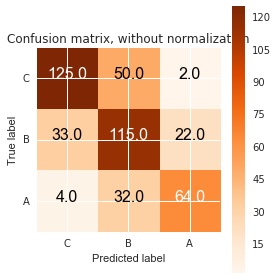

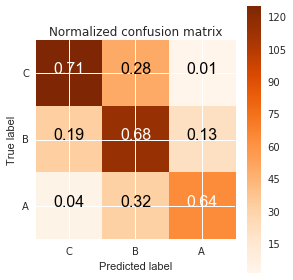

In [1254]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(4,4))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(4,4))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [1213]:
64/(64+22+2.0)

0.7272727272727273

In [ ]:
airbnb.review_scores_location.value_counts()

In [1009]:
df.chg_housing_value_median.mean()

-12857.143873919675

In [1010]:
df.chg_household_income_median.mean()

2219.131341868184

In [1011]:
df.chg_housing_units.mean()

23.507152745731425

In [1012]:
df.chg_population.mean()

104.24965389940009